In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Models Estimation

In [7]:
path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/ecoflex_181221_rf_rd_data/'
path1 = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/x_y_data_all_points/'
train_path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/percep_fbl_rf_rd_seperately_data/'

path2 = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/'
arr = np.array(pd.read_csv(path2+'x_y_value_for_all_points.csv', names = ['x','y']))
print(arr.shape)
arr[:5]

(200, 2)


array([[-0.0005, -0.026 ],
       [-0.0005,  0.017 ],
       [-0.0008,  0.0183],
       [-0.0009, -0.0115],
       [-0.0009,  0.0066]])

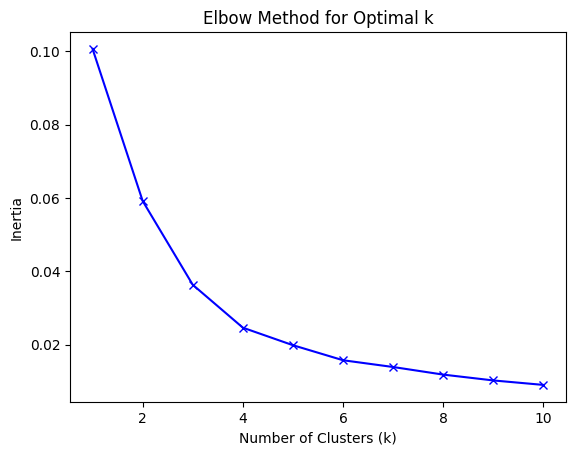

In [8]:
from sklearn.cluster import KMeans
k_values = range(1, 11)

# Perform k-means clustering for each k value
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(arr)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(arr)
kmeans.cluster_centers_

array([[ 0.01478   , -0.014034  ],
       [-0.01118718,  0.00201538],
       [-0.01482857,  0.0219    ],
       [-0.01369512, -0.02020976],
       [ 0.01110408,  0.01444898]])

In [19]:
from collections import defaultdict
d = defaultdict(lambda: [])
for i in range(200):
    label = kmeans.predict([arr[i]])[0]
    d[label].append(i)

for i in range(5):
    print(d[i])

[108, 110, 111, 114, 118, 121, 124, 126, 131, 132, 133, 135, 136, 137, 138, 141, 142, 143, 144, 147, 148, 149, 151, 152, 154, 155, 158, 161, 164, 169, 170, 173, 176, 178, 179, 180, 181, 182, 185, 186, 187, 188, 190, 192, 194, 195, 196, 197, 198, 199]
[4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 21, 23, 24, 25, 29, 32, 34, 39, 41, 42, 43, 45, 46, 48, 50, 64, 67, 68, 69, 73, 75, 78, 81, 89, 92, 93, 94, 100, 104]
[5, 9, 15, 19, 28, 36, 51, 52, 55, 58, 62, 63, 65, 66, 70, 79, 85, 90, 96, 97, 99]
[0, 3, 11, 16, 20, 22, 26, 27, 30, 31, 33, 35, 37, 38, 40, 44, 47, 49, 53, 54, 56, 57, 59, 60, 61, 71, 72, 74, 76, 77, 80, 82, 83, 84, 86, 87, 88, 91, 95, 98, 105]
[1, 2, 101, 102, 103, 106, 107, 109, 112, 113, 115, 116, 117, 119, 120, 122, 123, 125, 127, 128, 129, 130, 134, 139, 140, 145, 146, 150, 153, 156, 157, 159, 160, 162, 163, 165, 166, 167, 168, 171, 172, 174, 175, 177, 183, 184, 189, 191, 193]


In [27]:
from scipy.linalg import norm

def dist(i):
    at = -1
    mini = 10
    for j in range(len(d[i])):
        dis = ((arr[d[i][j]][0]- kmeans.cluster_centers_[i][0])**2 + (arr[d[i][j]][1]- kmeans.cluster_centers_[i][1])**2)**0.5
        if dis <mini:
            mini = dis 
            at = j
    print(f'{d[i][at]+1} is the master node of {i}th cluster')
    print(arr[d[i][at]], kmeans.cluster_centers_[i],'\n')
for i in range(5):
    dist(i)

162 is the master node of 0th cluster
[ 0.0159 -0.0166] [ 0.01478  -0.014034] 

40 is the master node of 1th cluster
[-0.0103  0.0031] [-0.01118718  0.00201538] 

52 is the master node of 2th cluster
[-0.014   0.0232] [-0.01482857  0.0219    ] 

45 is the master node of 3th cluster
[-0.0122 -0.0208] [-0.01369512 -0.02020976] 

147 is the master node of 4th cluster
[0.0119 0.0134] [0.01110408 0.01444898] 



# Training and Evaluation of Clusters

In [32]:
x1 = np.array(pd.read_csv(path+f'{162}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{162}_force_ecoflex_181221_derivative_data.csv'))
l = len(y1)
arr = np.array(pd.read_csv(path1+f'{162}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
x2 = np.concatenate([x1,arr], axis = 1)
rf = RandomForestRegressor()
rf.fit(x2,y1)

RandomForestRegressor()

In [33]:
error = []
array = np.array(d[0])+1
for i in array:
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    x2 = np.concatenate([x1,arr], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))

0.38808968997829024


In [34]:
x1 = np.array(pd.read_csv(path+f'{40}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{40}_force_ecoflex_181221_derivative_data.csv'))
l = len(y1)
arr = np.array(pd.read_csv(path1+f'{40}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
x2 = np.concatenate([x1,arr], axis = 1)
rf = RandomForestRegressor()
rf.fit(x2,y1)

error = []
array = np.array(d[1])+1
for i in array:
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    x2 = np.concatenate([x1,arr], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))

0.4749449885112794
1.432503914484652 0.02053431099787685


In [35]:
x1 = np.array(pd.read_csv(path+f'{52}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{52}_force_ecoflex_181221_derivative_data.csv'))
l = len(y1)
arr = np.array(pd.read_csv(path1+f'{52}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
x2 = np.concatenate([x1,arr], axis = 1)
rf = RandomForestRegressor()
rf.fit(x2,y1)

error = []
array = np.array(d[2])+1
for i in array:
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    x2 = np.concatenate([x1,arr], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))

0.19183919820944903
0.40148130913317626 0.02355151354971785


In [36]:
x1 = np.array(pd.read_csv(path+f'{45}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{45}_force_ecoflex_181221_derivative_data.csv'))
l = len(y1)
arr = np.array(pd.read_csv(path1+f'{45}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
x2 = np.concatenate([x1,arr], axis = 1)
rf = RandomForestRegressor()
rf.fit(x2,y1)

error = []
array = np.array(d[3])+1
for i in array:
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    x2 = np.concatenate([x1,arr], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))

0.2623617528171891
0.8334688181214157 0.011827684866475585


In [37]:
x1 = np.array(pd.read_csv(path+f'{147}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
y1 = np.array(pd.read_csv(path+f'{147}_force_ecoflex_181221_derivative_data.csv'))
l = len(y1)
arr = np.array(pd.read_csv(path1+f'{147}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
x2 = np.concatenate([x1,arr], axis = 1)
rf = RandomForestRegressor()
rf.fit(x2,y1)

error = []
array = np.array(d[4])+1
for i in array:
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    x2 = np.concatenate([x1,arr], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))
print(max(error), min(error))

0.29748046423584884
0.6802719037327731 0.021342145201936873
